# Building a Python Model of the ULP Feature Extractor IC

The goal is to build a python model of the feature extractor IC so that it can be used to test and train a full ML collision system feature the feature extraction IC and a detection algorithmn on FPGA/uC 

## Band Pass Filters
The first stage of the feature extractor IC is a set of 8 band pass filters that seperate the signal into varying sized and spaced bands (evenly spaced in the log domain) These should model well as second order transfer functions based on the capactiance and gm values shown in the extracted simulations. These sims use extracted layouts for the biasing network too.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('./new_plot_style.mplstyle')

img_path = './img/bpf/'
data_path = './data/'

## Plot the Simulation data
First we will load in and then plot the simulation data

In [39]:
bpf_import = pd.read_csv("./data/filters.csv")

bpf_import.head()

,vout_ac X,vout_ac Y,vout_ac X.1,vout_ac Y.1,vout_ac X.2,vout_ac Y.2,vout_ac X.3,vout_ac Y.3,vout_ac X.4,vout_ac Y.4,vout_ac X.5,vout_ac Y.5,vout_ac X.6,vout_ac Y.6,vout_ac X.7,vout_ac Y.7
0,10.00,-18.380828,10.00,-24.270885,10.00,-29.759787,10.00,-34.133122,10.00,-36.609561,10.00,-37.535700,10.00,-37.648919,10.00,-37.560017
1,29.98,-8.751892,29.98,-14.833620,49.98,-16.406429,89.98,-17.309420,89.98,-23.216701,89.98,-28.734346,89.98,-33.279424,89.98,-35.788533
2,49.96,-4.182656,49.96,-10.363706,89.96,-11.282589,169.96,-11.777418,169.96,-17.792402,169.96,-23.608999,169.96,-29.066466,169.96,-33.117438
3,69.94,-1.176169,69.94,-7.384608,129.94,-8.037643,249.94,-8.381444,249.94,-14.451709,249.94,-20.344759,249.94,-26.048854,249.94,-30.706719
4,89.92,0.894729,89.92,-5.135972,169.92,-5.644450,329.92,-5.911079,329.92,-12.030106,329.92,-17.961860,329.92,-23.764915,329.92,-28.697280


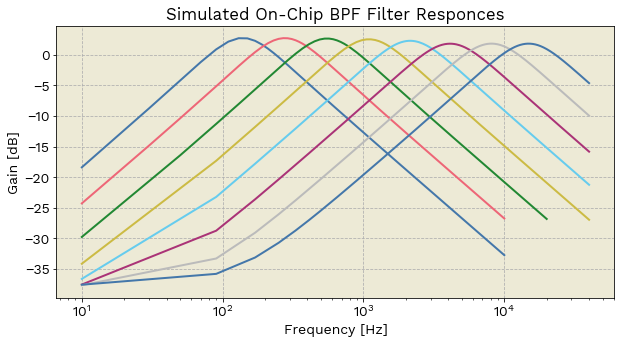

In [40]:
col = bpf_import.columns
fig,ax = plt.subplots(1,figsize=[10,5], sharex=True)
i = 0
while i<len(col):
    ax.semilogx(bpf_import[col[i]], bpf_import[col[i+1]],linewidth=2)
    i = i +2
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Gain [dB]")
ax.set_title("Simulated On-Chip BPF Filter Responces")
fig.savefig(img_path+"sim_onchip_bpf_responce.svg")


/var/folders/p_/7b1s1nqx0295px2gxzljkx3c0000gn/T/ipykernel_12915/1169281749.py:14: RuntimeWarning: divide by zero encountered in log10
  h_2 = 20*np.log10(np.abs(((-1*c2/gm2)*(1j*w2))/(((c1*c2)/(gm1*gm2))*(1j*w2)**2 + (c1/gm2)*(1j*w2) + 1)))


24399.862972595503

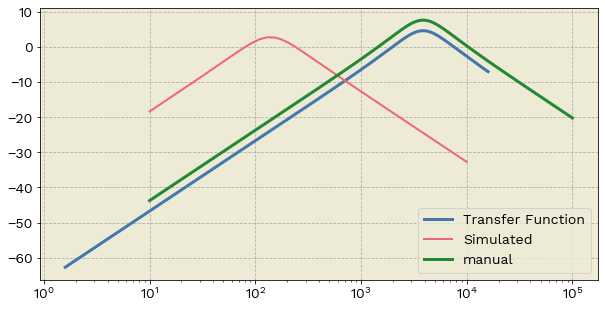

In [41]:
from scipy import signal

c1 = 2*750e-15
c2 = 2*1.8e-12
gm1 = 91.7679e-9
gm2 = 34.7765e-9

num = [-1*c2/gm2, 0]
den = [(c1*c2)/(gm1*gm2), c1/gm2, 1]
bpf_1 = signal.TransferFunction(num, den)

f = np.linspace(0,10e4,10000)
w2= np.pi*2*f
h_2 = 20*np.log10(np.abs(((-1*c2/gm2)*(1j*w2))/(((c1*c2)/(gm1*gm2))*(1j*w2)**2 + (c1/gm2)*(1j*w2) + 1)))

w,h = signal.freqs(num, den, worN=np.logspace(1, 5, 1000))

fig,ax = plt.subplots(1,figsize=[10,5], sharex=True)
ax.semilogx(w/2/np.pi, 20*np.log10(np.abs(h))-3,label="Transfer Function")
ax.semilogx(bpf_import[col[0]], bpf_import[col[1]],linewidth=2, label="Simulated")
ax.semilogx(f, h_2, label="manual")
ax.legend()

w[np.argmax(20*np.log10(abs(h)))]

In [7]:
c1 = [2*750e-15*32, 2*750e-15*16, 2*750e-15*8, 2*750e-15*4, 2*750e-15*2, 2*750e-15, 2*750e-15, 2*750e-15]
c2 = [2*1.8e-12*32, 2*1.8e-12*16, 2*1.8e-12*8, 2*1.8e-12*4, 2*1.8e-12*2, 2*1.8e-12, 2*1.8e-12, 2*1.8e-12]

gm1 = [91.7679e-9, 91.8279e-9, 91.8269e-9, 91.8269e-9, 91.8269e-9, 91.1552e-9, 178.72e-9, 326.848e-9] 
gm2 = [34.7765e-9, 34.7996e-9, 34.7992e-9, 34.7992e-9, 34.7992e-9, 34.5252e-9, 68.4916e-9, 127.022e-9]

col = bpf_import.columns
bpfs = []
nums = []
dens = []
fig,ax = plt.subplots(1,figsize=[10,5], sharex=True)
i = 0
ii = 0
while i<len(col):
    num = [-1*c2[ii]/gm2[ii], 0]
    nums.append(num)
    den = [(c1[ii]*c2[ii])/(gm1[ii]*gm2[ii]), c1[ii]/gm2[ii], 1]
    dens.append(den)
    bpf_1 = signal.TransferFunction(num, den)
    bpfs.append(bpf_1)
    ii = ii+1

    w,h = signal.freqs(num, den, worN=np.logspace(1, 6, 1000))
    ax.semilogx(bpf_import[col[i]], bpf_import[col[i+1]],linewidth=2,c="C0")
    ax.semilogx(w/2/np.pi, 20*np.log10(np.abs(h))-5.5,linewidth=2, c="C1")    
    i = i +2
ax.set_xlim([10, 1e5])
ax.set_ylim([-40, 5])
ax.legend(["Sim", "Model"])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Gain [dB]")
ax.set_title("Simulated vs Modeled On-Chip BPF Filter Responces")
fig.savefig(img_path+"simvmodel_onchip_bpf_responce.svg")

NameError: name 'bpf_import' is not defined

## Transconductance and Full Wave Rectifier 

The transconductance (gm) block and the full wave rectifier block (FWR) transform the bandpassed signals from the voltage domain to the current domain for simple integration. To capture the energy in the band after the gm block converts it into a current it is then rectified attempting to apply the mathmatical function of absolute value in the analog domain

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

plt.style.use('./new_plot_style.mplstyle')

img_path = './img/gm_fw/'
data_path = './data/'

### Ploting the Simulated Data
First lets import the data from the chip spice simulation to see what current comes out of a input voltage differential. Ideally, the FWR is just doing the mathmatical operation of absolute value so we can plot the abs of GM to see if any differences arises there.

In [44]:
gm_fw_import = pd.read_csv('./data/gm_FW_large.csv')

col = gm_fw_import.columns

df_gm_fw = gm_fw_import.rename(columns={col[0]: "Voltage", col[1]: "Gm", col[2]: "Voltage1", col[3]: "FWR"})
df_gm_fw.head()

,Voltage,Gm,Voltage1,FWR
0,-0.5000,-3.041169e-08,-0.5000,3.404726e-08
1,-0.4995,-3.041137e-08,-0.4995,3.404691e-08
2,-0.4990,-3.041105e-08,-0.4990,3.404655e-08
3,-0.4985,-3.041073e-08,-0.4985,3.404620e-08
4,-0.4980,-3.041040e-08,-0.4980,3.404584e-08


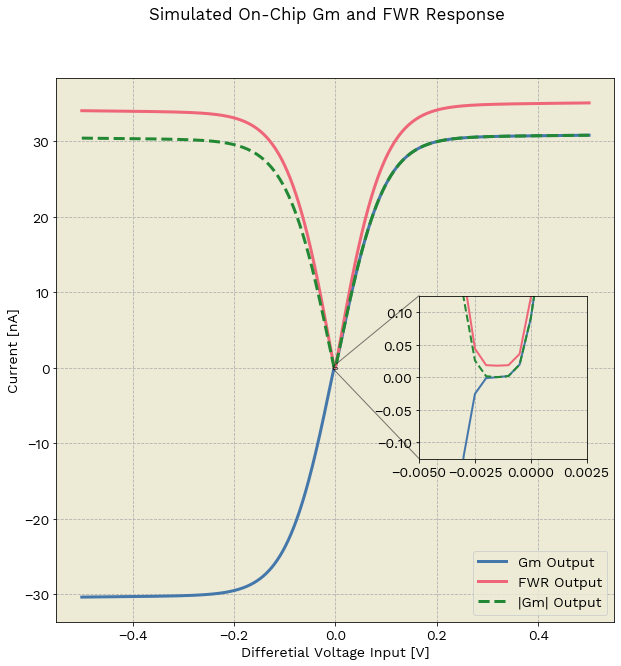

In [45]:
fig,ax = plt.subplots(1,figsize=[10,10], sharex=True)
fig.suptitle("Simulated On-Chip Gm and FWR Response")
ax.plot(df_gm_fw["Voltage"], df_gm_fw["Gm"]*1e9, label="Gm Output")
ax.set_ylabel("Current [nA]")
ax.legend()

ax.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output")
ax.set_ylabel("Current [nA]")
ax.set_xlabel("Differetial Voltage Input [V]")


ax.plot(df_gm_fw["Voltage"], np.abs(df_gm_fw["Gm"]*1e9), label="|Gm| Output",linestyle="dashed")
ax.legend()
axins = ax.inset_axes([0.65, 0.3, 0.3, 0.3])


x1, x2, y1, y2 = -0.005, 0.0025, -.125, .125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
axins.plot(df_gm_fw["Voltage"], df_gm_fw["Gm"]*1e9, label="Gm Output", linewidth=2)
axins.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output", linewidth=2)
axins.plot(df_gm_fw["Voltage"], np.abs(df_gm_fw["Gm"]*1e9), label="|Gm| Output",linestyle="dashed", linewidth=2)

ax.indicate_inset_zoom(axins, edgecolor="black")


fig.savefig(img_path+"sim_gm_FWR.svg")


Clearly theres a small difference in scaling and a minimum current offset between the FWR output compared to just taking the absolute value of the Gm cell, lets try adding the offset and scaling

(<matplotlib.patches.Rectangle at 0x14c478be0>,
 (<matplotlib.patches.ConnectionPatch at 0x14c493580>,
  <matplotlib.patches.ConnectionPatch at 0x14c493fa0>))

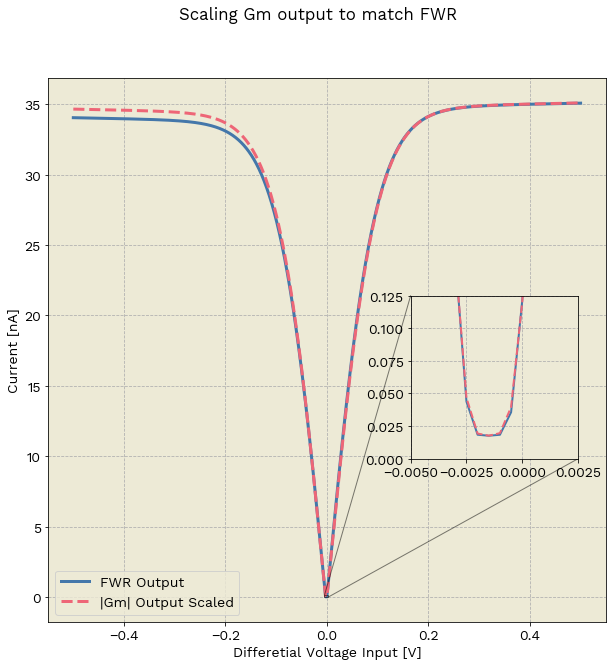

In [46]:
scale_factor =max(df_gm_fw["FWR"])/max(df_gm_fw["Gm"])

offset = min(df_gm_fw["FWR"])*1e9

fig,ax = plt.subplots(1,figsize=[10,10], sharex=True)
fig.suptitle("Scaling Gm output to match FWR")

ax.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output")
ax.plot(df_gm_fw["Voltage"], (np.abs(df_gm_fw["Gm"])*scale_factor)*1e9+offset, label="|Gm| Output Scaled",linestyle="dashed")

ax.set_ylabel("Current [nA]")
ax.set_xlabel("Differetial Voltage Input [V]")
ax.legend()
axins = ax.inset_axes([0.65, 0.3, 0.3, 0.3])
x1, x2, y1, y2 = -0.005, 0.0025, 0, .125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
axins.plot(df_gm_fw["Voltage"], df_gm_fw["FWR"]*1e9, label="FWR Output", linewidth=2)
axins.plot(df_gm_fw["Voltage"], (np.abs(df_gm_fw["Gm"])*scale_factor)*1e9+offset, label="|Gm| Output",linestyle="dashed", linewidth=2)

ax.indicate_inset_zoom(axins, edgecolor="black")

### Curve Fitting

Now we can try to fit a curve to each of these lines, There are 4 approaches to try:
    
1. Fit a curve to the gm output then scale and add offset like was shown
2. Fit a curve to the FWR output
3. Do a piece wise solution for the FWR output
4. **Use machine a machine learning regression model to fit the curve**

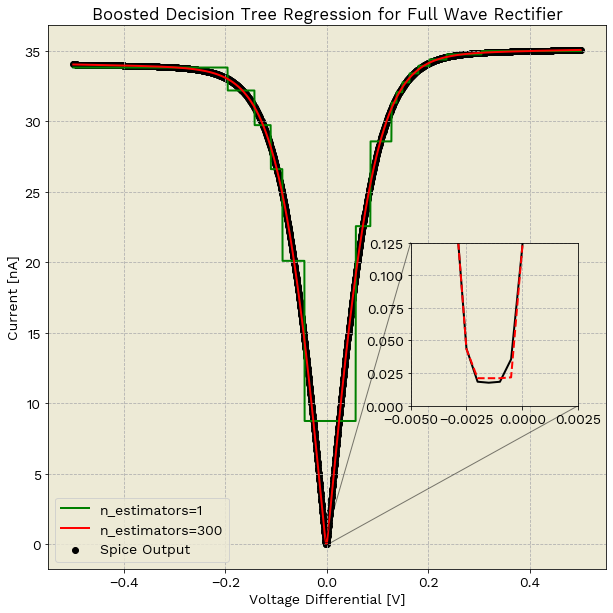

In [47]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)
X = np.array(df_gm_fw["Voltage"]).reshape(-1,1)
y = df_gm_fw["FWR"].ravel()*1e9

regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=13),
                          n_estimators=400, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

fix, ax = plt.subplots(figsize=[10,10])
ax.scatter(X, y, c='k', label="Spice Output")
ax.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
ax.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
ax.set_xlabel("Voltage Differential [V]")
ax.set_ylabel("Current [nA]")
ax.set_title("Boosted Decision Tree Regression for Full Wave Rectifier")
ax.legend()

axins = ax.inset_axes([0.65, 0.3, 0.3, 0.3])
x1, x2, y1, y2 = -0.005, 0.0025, 0, .125
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
axins.plot(X, y, c='k', linewidth=2)
axins.plot(X, y_2,c='r', linestyle="dashed", linewidth=2)


ax.indicate_inset_zoom(axins, edgecolor="black")

fig.savefig(img_path+"adaboost_regression_FWR.svg")

In [48]:
np.size(X)

2001

This looks like a suitable model for this section of the chip we will use this

## Capacitor Integrator

The voltage on a capacitor can be related in terms of a time varying current depositing or removing charge stored in the capacitor. In this system we are using a capacitor as an integrator/accumulator to count the sum total of charge delivered out of the the FWR stage. The voltage on the capacitor can related to the change of current as $$V_x = \frac{1}{c}dtI+V_0$$

From this we can set a threshold for V and have one dt step make the pulse go high and reset the voltage on the capcitor. 

First lets try a simple approximation of this.

Text(0.5, 1.0, 'Pulse Frequency vs Input Current')

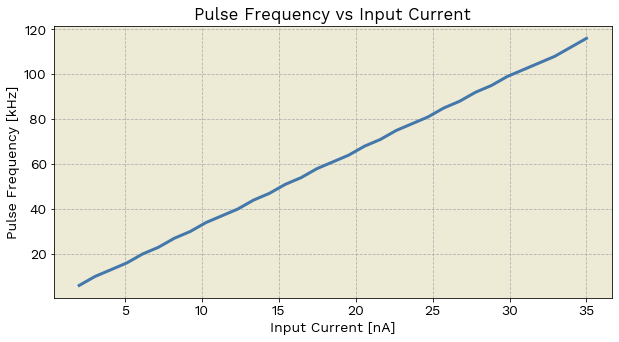

In [3]:
# set dT by using the sample rate step time for the patch data this is 4000Hz sample rate

time_ms = .001
dt = .001/10000
time = np.linspace(0, time_ms, int(time_ms/dt))

I = np.linspace(2,35,(35-2))*1e-9

c = 500e-15


pulse_freq = np.zeros(len(I))
for outterindex , current in enumerate(I):
    Vx = np.zeros(len(time))
    pulses = np.zeros(len(time))
    for index, _ in enumerate(time):
        if index == 0:
            pass
        else:
            Vx[index] = Vx[index - 1] + (1/c)*dt*current
            #print(Vx[index])

            if Vx[index] > 0.6:
                pulses[index] = 1
                Vx[index] = 0
    
    pulse_freq[outterindex] = sum(pulses)/0.001
    

fig, ax = plt.subplots(figsize=[10,5])

ax.plot(I*1e9,pulse_freq*1e-3)
ax.set_xlabel("Input Current [nA]")
ax.set_ylabel("Pulse Frequency [kHz]")
ax.set_title("Pulse Frequency vs Input Current")

# Putting the Parts Together

Now we can start putting the parts together and maybe arrange them in a custom library for future use. Lets make a function for the FWR and IAF circuits and put them together in a simulation

In [50]:
def IAF(current_sig, dt, rate_crtl):
    if rate_crtl:
       c = 500e-15
    else:
        c = 250e-15

    Vx = np.zeros(len(current_sig))
    pulse_train = np.zeros(len(current_sig))

    for index in range(len(current_sig)):
        if index == 0:
           pass
        else:
            Vx[index] = Vx[index - 1] + (1/c)*dt*current_sig[index]

            if Vx[index] > 0.6:
                Vx[index] = 0
                pulse_train[index] = 1
    
    return pulse_train,Vx


In [51]:
def FWR(voltage_sig):
    X = np.array(voltage_sig).reshape(-1,1)
    current_sig = regr_2.predict(X)
    return current_sig*1e-9
    

In [52]:
def BPF(voltage_sig, time_series, bpfs):
    filtered_sigs = [] 
    for tf in bpfs:
        temp = np.zeros(len(voltage_sig))
        _,temp,_ = signal.lsim((tf.num, tf.den), voltage_sig,time_series)
        filtered_sigs.append(temp)
    
    return filtered_sigs 

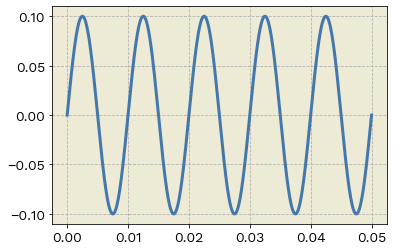

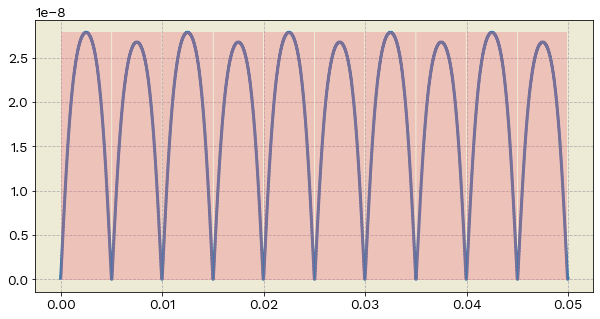

In [53]:
time_ms = .05
dt = .001/1000
time = np.linspace(0, time_ms, int(time_ms/dt))

voltage_sig = .1*np.sin(time*2*np.pi*100)

plt.plot(time,voltage_sig)

current_sig = FWR(voltage_sig=voltage_sig)

pulse_train,Vx = IAF(current_sig=current_sig,dt=dt,rate_crtl=0)

fig,ax = plt.subplots(figsize=[10,5])
ax.plot(time,current_sig)
ax.step(time, pulse_train*max(current_sig), linewidth=0.5, alpha=0.3)
test_sigs = BPF(voltage_sig=voltage_sig,time_series=time,bpfs=bpfs)

In [54]:
import pickle

filename = "./bandpass_filters_tf.pkl"
pickle.dump(bpfs, open(filename,'wb'))


In [55]:
filename = "./fwr_tf_regression.pkl"
pickle.dump(regr_2, open(filename,'wb'))

In [5]:
import bt_ic_model

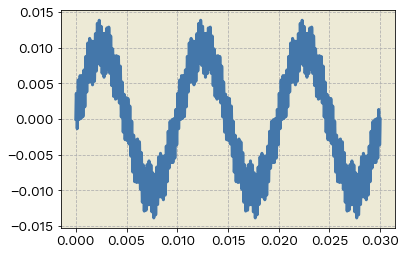

In [12]:
time_ms = .01
dt = .001/1000
time = np.linspace(0, time_ms*3, int(time_ms/dt)*3)

voltage_sig = .01*np.sin(time*2*np.pi*100) + 0.001*np.sin(time*2*np.pi*1000) + 0.003*np.sin(time*2*np.pi*5300)

plt.plot(time,voltage_sig)

filt_sigs = bt_ic_model.BPF(voltage_sig=voltage_sig,time_series=time, bpfs=bpfs)

pulse_trains, time_series = bt_ic_model.SimSignal(voltage_sig=voltage_sig,time_step=dt,bpfs=bpfs,FWR_model=FWR_model,rate_ctrl=1)


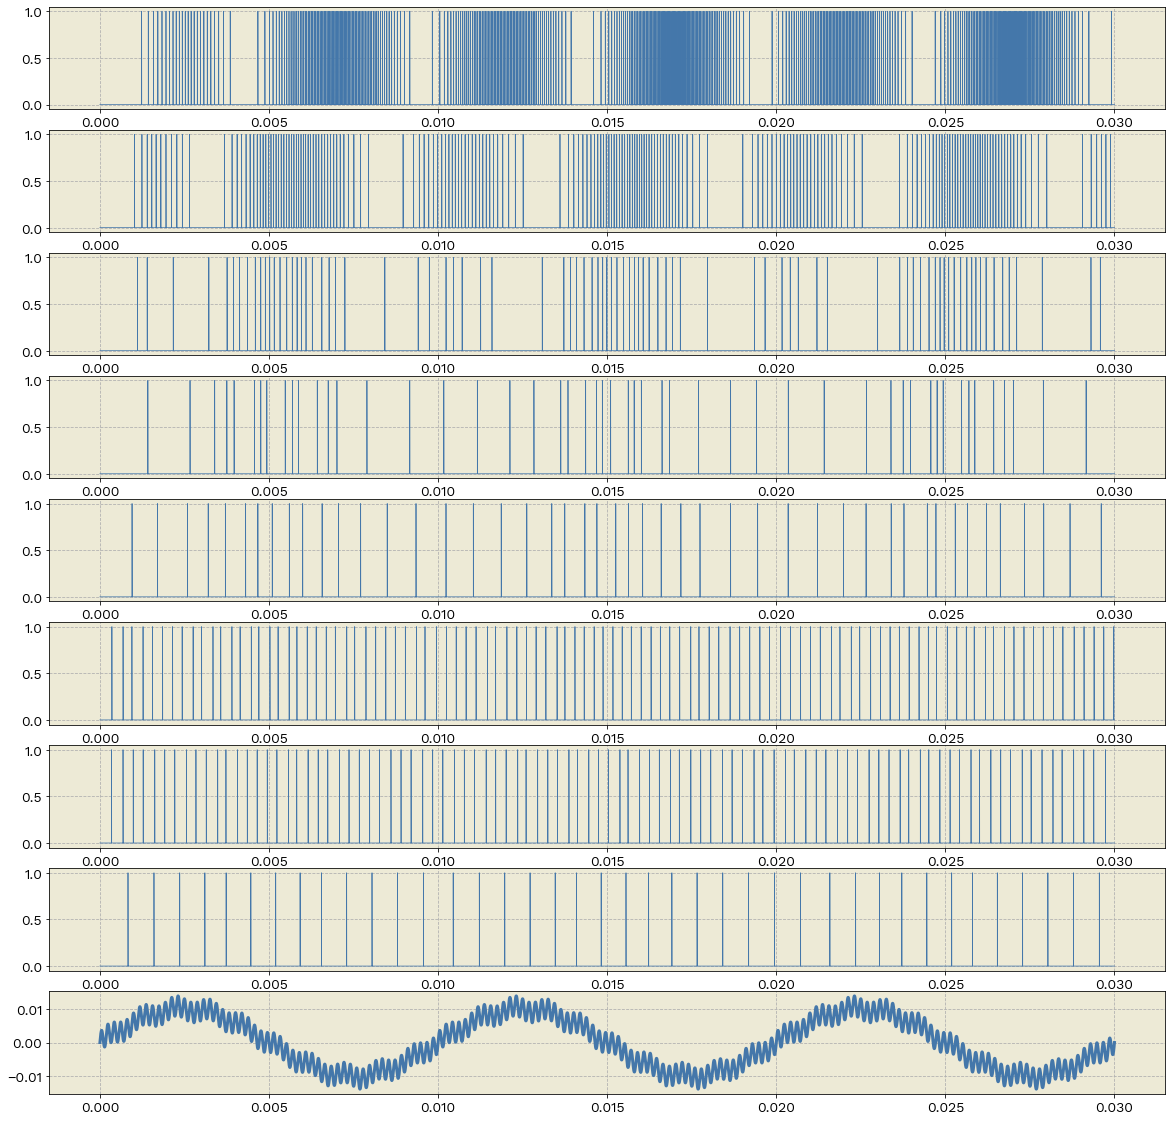

In [14]:
fig, axs = plt.subplots(9,1, figsize=[20,20])

for index, pulses_train in enumerate(pulse_trains):
    axs[index].step(time_series, pulse_trains[index][0], linewidth=0.75)

axs[8].plot(time_series,voltage_sig)

## Visualization

Lets look at incorperating some visulization techniques from prior work with the EDM, this is mainly to see how the pulse count density changes with an input signal

In [101]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
edms = np.zeros((len(pulse_trains),len(pulse_trains[0])))
l = 1/(np.power(2, 8))
for index, pulse_train in enumerate(pulse_trains):
    edm = bt_ic_model.EDM(pulse_train=pulse_train,alpha=8)
    edms[index,:] = edm

#edms = stats.zscore(edms)
std = (edms - np.min(edms)) / (np.max(edms) - np.min(edms))

edms = std

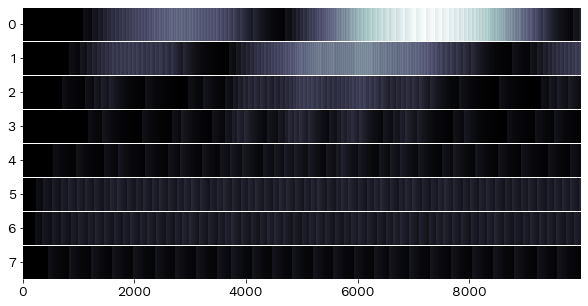

In [103]:

fig,ax = plt.subplots(figsize=[10,5])
im = ax.imshow(edms,aspect='auto',interpolation='none',vmin=0,cmap="bone")
ax.spines[:].set_visible(False)
#ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.grid(False)
ax.set_yticks(np.arange(edms.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)



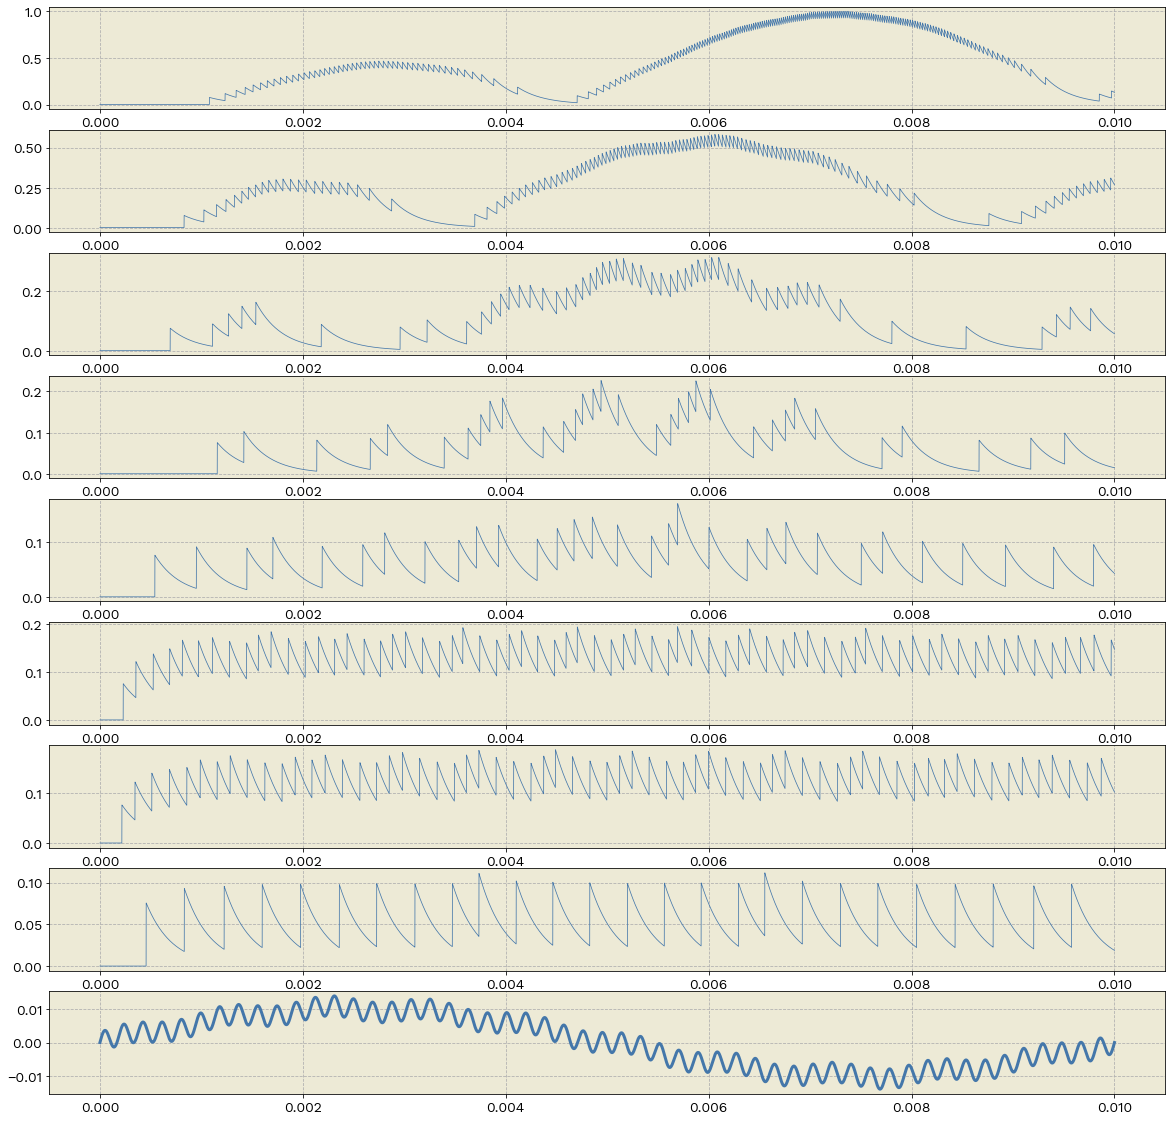

In [104]:
fig, axs = plt.subplots(9,1, figsize=[20,20])

for index, pulses_train in enumerate(edms):
    axs[index].plot(time_series, edms[index], linewidth=0.75)

axs[8].plot(time_series,voltage_sig)

## Testing a Wav Signal

Now lets try applying this to patch data to see how it looks, mainly want to know how much if any we need to upscale the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import bt_ic_model
import pickle

plt.style.use('./new_plot_style.mplstyle')

file_to_read = open("./bandpass_filters_tf.pkl","rb")

bpfs = pickle.load(file_to_read)

file_to_read = open("./fwr_tf_regression.pkl","rb")

FWR_model = pickle.load(file_to_read)
samplerate, data = wavfile.read("./10M_219.WAV")


/var/folders/p_/7b1s1nqx0295px2gxzljkx3c0000gn/T/ipykernel_36864/410854401.py:18: WavFileWarning: Reached EOF prematurely; finished at 509484 bytes, expected 509492 bytes from header.
  samplerate, data = wavfile.read("./10M_219.WAV")


In [2]:
time = np.linspace(0,len(data)/samplerate,len(data))
dt = 1/samplerate
dt_scaled = 1/(samplerate*250)

data_scaled = data[:,1]*(3.3/4095)

data_scaled = data_scaled - np.mean(data_scaled)
time = np.linspace(0,len(data_scaled)/samplerate,len(data_scaled))
dt = 1/samplerate
pulse_trains, time_series = bt_ic_model.SimSignal(voltage_sig=data_scaled,time_step=dt,time_step_pulse=dt_scaled, bpfs=bpfs,FWR_model=FWR_model,rate_ctrl=1)

In [26]:
np.shape(pulse_trains[0][0])

dbool = np.array(pulse_trains, dtype=bool)
np.shape(dbool)

(8, 1, 31840000)

In [37]:
reshaped = np.reshape(dbool, (8,len(dbool[0][0])))
packed = np.packbits(reshaped,axis=-1)
filename = "./10M_219_pulse_train.pkl"
pickle.dump(packed, open(filename,'wb'))

In [40]:
unpacked = np.unpackbits(packed,axis=-1)

In [44]:
np.shape(unpacked)

(8, 31840000)

ValueError: x and y must have same first dimension, but have shapes (127360,) and (400,)

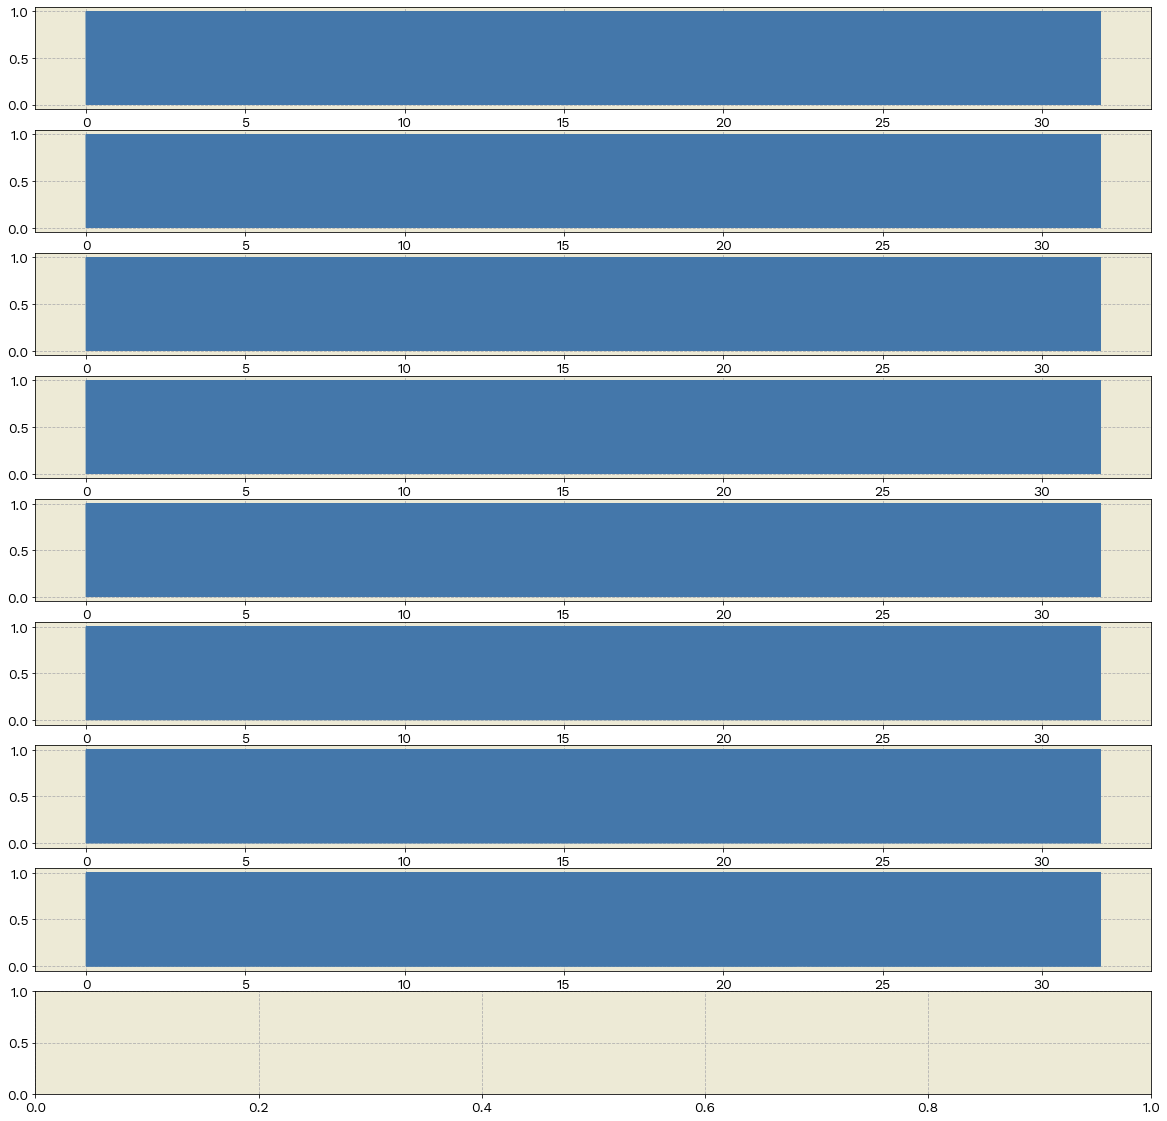

In [45]:
time_scaled = np.linspace(0,(len(data)*250)/(samplerate*250),len(data)*250)
fig, axs = plt.subplots(9,1, figsize=[20,20])

for index, pulses_train in enumerate(pulse_trains):
    axs[index].step(time_scaled, unpacked[index], linewidth=0.5)

axs[8].plot(time,data_scaled)


In [13]:
pulse_trains[0][0]

(array([0., 0., 0., ..., 0., 0., 0.]), 3.183544964960431)

In [9]:
edms = np.zeros((len(pulse_trains),len(pulse_trains[0][0])))
for index, pulse_train in enumerate(pulse_trains):
    edm = bt_ic_model.EDM(pulse_train=pulse_trains[index][0],alpha=20)
    print(np.shape(edm))
    edms[index,:] = edm

(31840000,)
(31840000,)
(31840000,)
(31840000,)
(31840000,)
(31840000,)
(31840000,)
(31840000,)


Text(0, 0.5, 'Feature Vector')

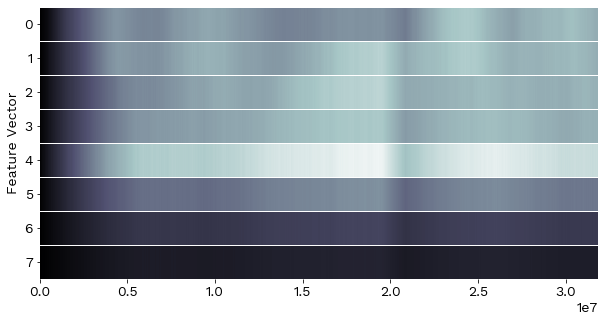

In [10]:
fig,ax = plt.subplots(figsize=[10,5])
im = ax.imshow(edms,aspect='auto',interpolation='none',vmin=0,cmap="bone")
ax.spines[:].set_visible(False)
#ax.set_xticks(time_scaled, minor=True)
ax.grid(False)
ax.set_yticks(np.arange(edms.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)
ax.set_ylabel("Feature Vector")

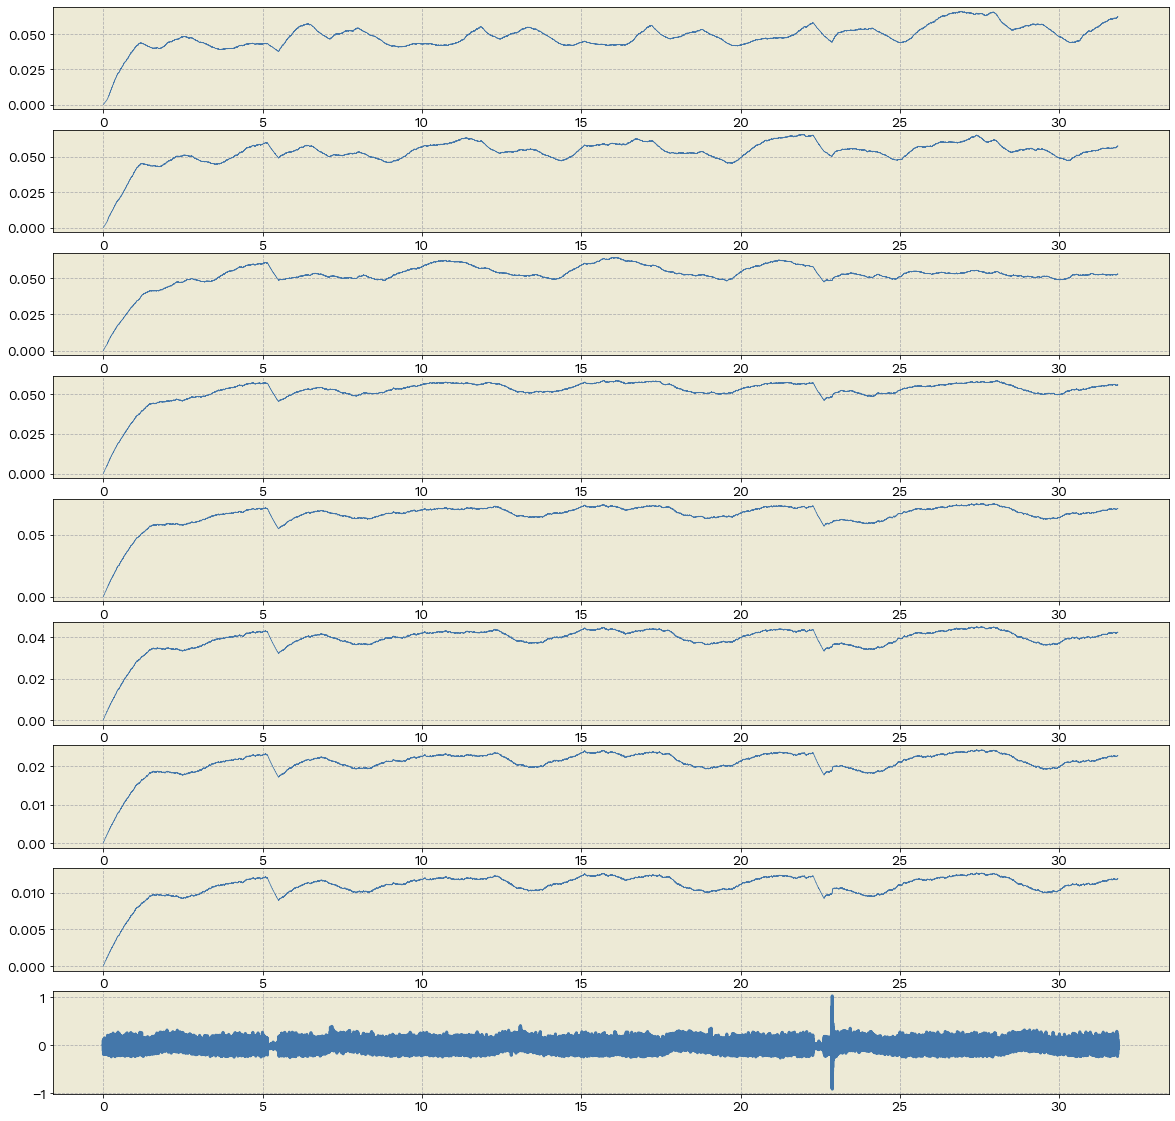

In [11]:
fig, axs = plt.subplots(9,1, figsize=[20,20])
time_scaled = np.linspace(0,(len(data)*250)/(samplerate*250),len(data)*250)

for index, pulses_train in enumerate(edms):
    axs[index].plot(time_scaled, edms[index], linewidth=0.75)

axs[8].plot(time_series,data_scaled)


Right now this data is a too low of a sample rate to be useful, the pulses cannot resolve before more energy is added into the system, lets try upsampling to resolve a smaller dt where now the pulse width is 1uS

In [5]:
len(data_scaled)
time_slice = time[0:100]

(time>20) & (time <25)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [6]:
data_upsampled = signal.resample(data_scaled[0:100],len(time_slice)*250)

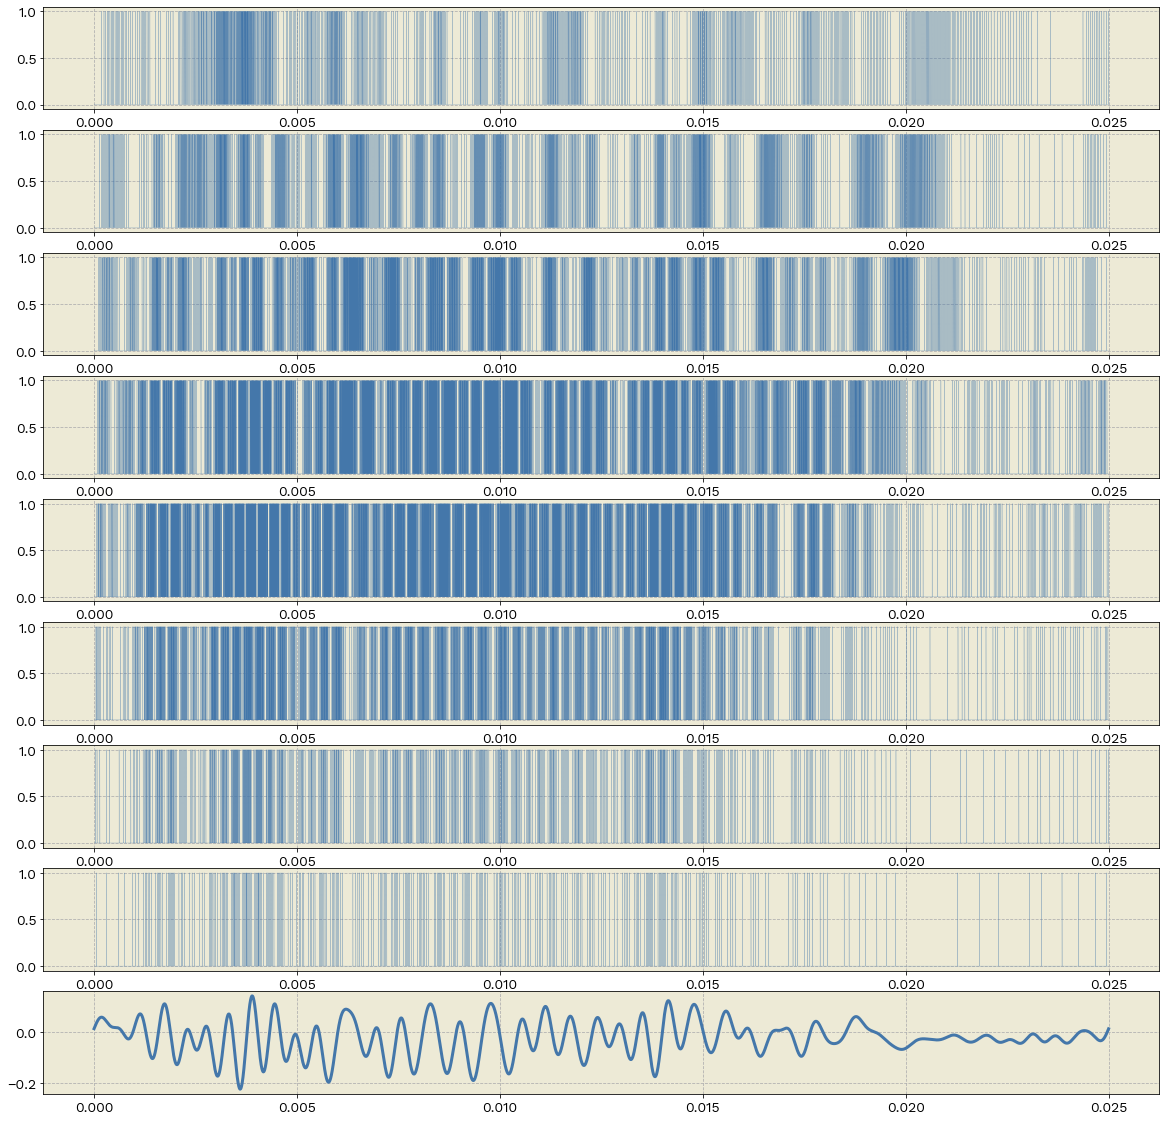

In [27]:
time_scaled = np.linspace(0,len(data_upsampled)/(samplerate*250),len(data_upsampled))
dt_scaled = 1/(samplerate*250)

pulse_trains_scaled, time_series_scaled = bt_ic_model.SimSignal(voltage_sig=data_upsampled,time_step=dt_scaled,bpfs=bpfs,FWR_model=FWR_model,rate_ctrl=1)
fig, axs = plt.subplots(9,1, figsize=[20,20])

for index, pulses_train in enumerate(pulse_trains):
    axs[index].step(time_series_scaled, pulse_trains_scaled[index][0], linewidth=0.2)

axs[8].plot(time_series_scaled,data_upsampled)

In [8]:
print(sum(pulse_trains[0][0]))
print(sum(pulse_trains_scaled[0][0]))
dt/dt_scaled

87.0
733.0


250.00000000000003

In [26]:
c = 500e-15
filtered_test = bt_ic_model.BPF(voltage_sig=data_scaled[0:100],time_series=time[0:100],bpfs=bpfs)
test_current_val = bt_ic_model.FWR(voltage_sig=filtered_test[0], model=FWR_model)
num_pulses = 0
pulse_train_int = np.zeros(len(test_current_val)*int(dt/dt_scaled))
for index, current_val in enumerate(test_current_val):
    vx = current_val*dt*(1/c)
    if vx > 0.6:
        num_pulses = np.floor(vx/0.6)
        vx_prior = vx - num_pulses*0.6
        pulse_index = np.floor(250/num_pulses)
        for j in range(int(num_pulses)):
            pulse_train_int[int(index*250+(pulse_index *j))] = 1
    else:
        vx_prior = vx



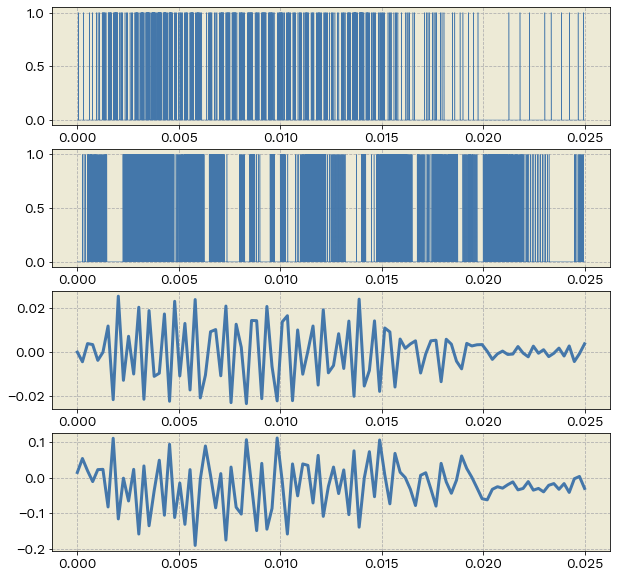

In [34]:
fig, axs = plt.subplots(4,1, figsize=[10,10])

axs[0].step(time_series_scaled, pulse_trains_scaled[index][0],linewidth=0.5)
axs[1].step(time_series_scaled, pulse_train_int, linewidth=0.5)
axs[2].plot(time_series,filtered_test[7])
axs[3].plot(time_series,data_scaled[0:100])

In [21]:
edms = np.zeros((len(pulse_trains),len(pulse_trains[0][0])))
for index, pulse_train in enumerate(pulse_trains):
    edm = bt_ic_model.EDM(pulse_train=pulse_trains[index][0],alpha=9)
    edms[index,:] = edm

Text(0, 0.5, 'Feature Vector')

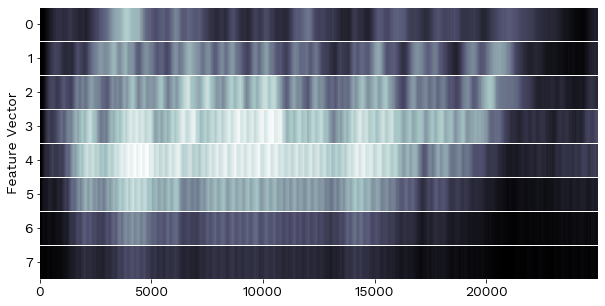

In [22]:
fig,ax = plt.subplots(figsize=[10,5])
im = ax.imshow(edms,aspect='auto',interpolation='none',vmin=0,cmap="bone")
ax.spines[:].set_visible(False)
#ax.set_xticks(np.arange(edms.shape[1]+1)-.5, minor=True)
ax.grid(False)
ax.set_yticks(np.arange(edms.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)
ax.set_ylabel("Feature Vector")

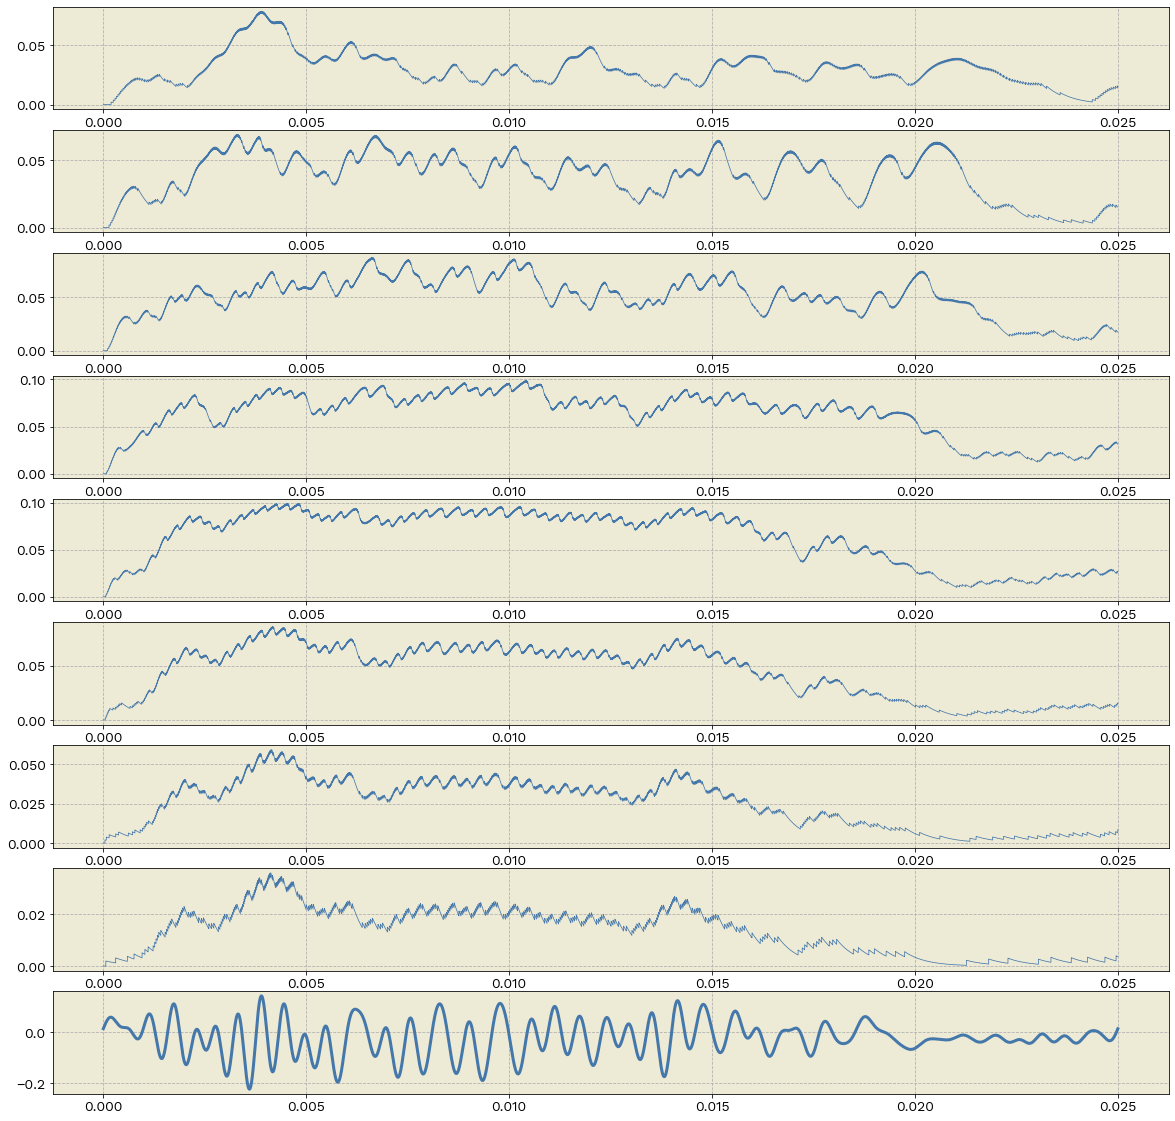

In [23]:
fig, axs = plt.subplots(9,1, figsize=[20,20])

for index, pulses_train in enumerate(edms):
    axs[index].plot(time_series, edms[index], linewidth=0.75)

axs[8].plot(time_series,data_upsampled)